# Part IV: Build Transformer with PyTorch

In [112]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from torchsummary import summary

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Exploring & Pre processing

### Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above. Briefly justify your choice in the report

In [8]:
data = pd.read_csv('/content/train.csv', header=None)

In [9]:
data.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


2. Data exploration

- Read, preprocess, and print the main statistics about the dataset
- Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [10]:
data.shape

(120000, 3)

In [11]:
data.isnull().sum()

0    0
1    0
2    0
dtype: int64

In [12]:
data.describe()

,0
count,120000.000000
mean,2.500000
std,1.118039
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [13]:
unique_counts = data[0].value_counts()
print("Number of unique values in the column 0: ", unique_counts)

Number of unique values in the column 0:  0
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


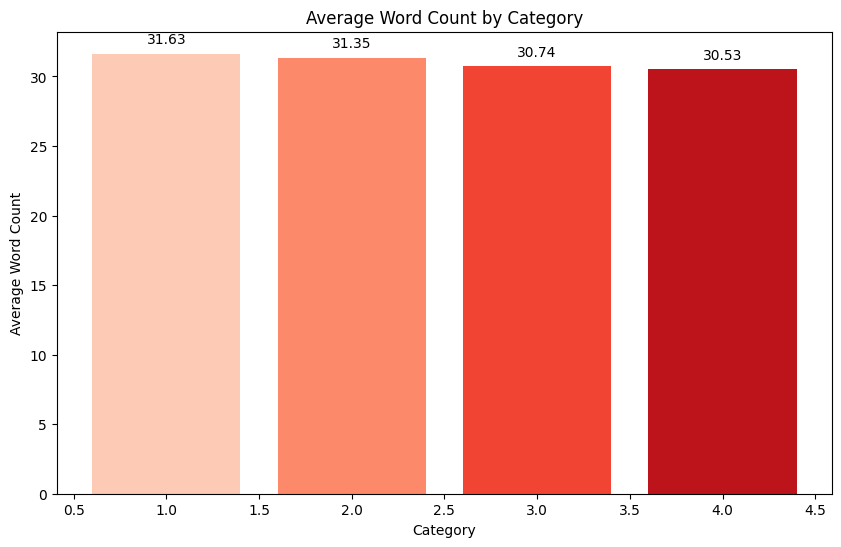

In [16]:
# Visualizatin 1

data['Word Count'] = data[2].apply(lambda x: len(x.split()))
avg_word_count = data.groupby(0)['Word Count'].mean()

plt.figure(figsize=(10, 6))
colors = sns.color_palette('Reds', len(avg_word_count))
bars = plt.bar(avg_word_count.index, avg_word_count.values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.title('Average Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.show()

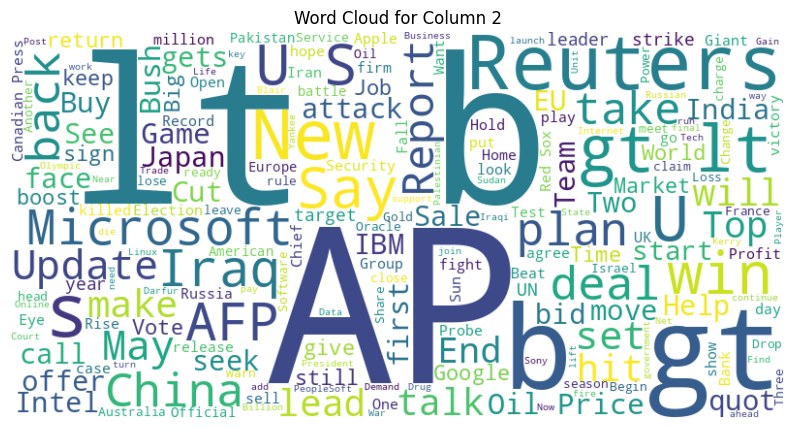

In [21]:
# Visualizatin 2

text_column2 = ' '.join(data[1].astype(str))
wordcloud_column2 = WordCloud(width=800, height=400, background_color='white').generate(text_column2)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_column2, interpolation='bilinear')
plt.title('Word Cloud for Column 2')
plt.axis('off')
plt.show()

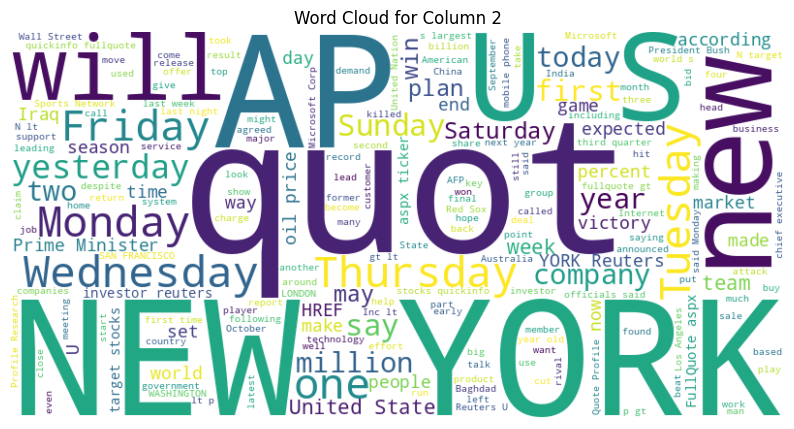

In [22]:
# Visualizatin 3

text_column2 = ' '.join(data[2].astype(str))
wordcloud_column2 = WordCloud(width=800, height=400, background_color='white').generate(text_column2)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_column2, interpolation='bilinear')
plt.title('Word Cloud for Column 2')
plt.axis('off')
plt.show()

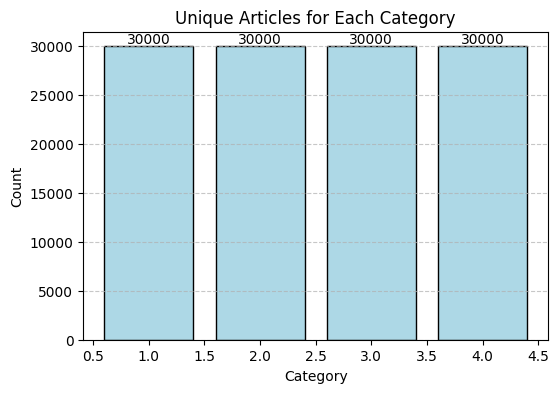

In [30]:
plt.figure(figsize=(6, 4))
bars = plt.bar(unique_counts.index, unique_counts.values, color='lightblue', edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

plt.title('Unique Articles for Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
data.head(10)

,0,1,2,Word Count
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",12
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,30
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,29
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,27
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",24
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,30
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...,28
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...,32
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...,65
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre...",15


In [33]:
data = data.drop('Word Count', axis = 1)

In [34]:
data.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


3. Text Processing

- Text cleaning. Remove punctuation, stop words, and unnecessary characters.
- Text lowercasing. Ensure all text is lowercase for consistent representation.
- Tokenization. Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
- Vocabulary building. Create a vocabulary containing all unique tokens encountered in the dataset.
- Numerical representation. Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [35]:
data.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [36]:
data[1] = data[1] + ' ' + data[2]

In [37]:
data.drop(columns=[2], inplace=True)

In [38]:
def has_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols or pictographs
                               u"\U0001F680-\U0001F6FF"  # transport or map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))
has_emojis = data[1].apply(has_emoji)

if has_emojis.any():
    print("The DataFrame contains emojis.")
else:
    print("The DataFrame does not contain any emojis.")


The DataFrame does not contain any emojis.


In [39]:
data[1] = data[1].str.lower()

In [40]:
duplicate_count = data.duplicated().sum()
print("Number of duplicates:", duplicate_count)

Number of duplicates: 65


In [41]:
data = data.drop_duplicates()

In [42]:
data.shape

(119935, 2)

In [43]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def rem_stop(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
data[1] = data[1].apply(rem_stop)

In [45]:
def remove_punctuations(text):
    if isinstance(text, str):
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
    return text

data[1] = data[1].apply(remove_punctuations)

In [46]:
data.head()

,0,1
0,3,wall st bears claw back black reuters reuter...
1,3,carlyle looks toward commercial aerospace reu...
2,3,oil economy cloud stocks outlook reuters re...
3,3,iraq halts oil exports main southern pipeline ...
4,3,oil prices soar alltime record posing new men...


In [47]:
duplicate_count = data.duplicated().sum()
print("Number of duplicates:", duplicate_count)

Number of duplicates: 178


In [48]:
data = data.drop_duplicates()

In [49]:
data.head()

,0,1
0,3,wall st bears claw back black reuters reuter...
1,3,carlyle looks toward commercial aerospace reu...
2,3,oil economy cloud stocks outlook reuters re...
3,3,iraq halts oil exports main southern pipeline ...
4,3,oil prices soar alltime record posing new men...


In [50]:
features = data[1]
label = data[0]

X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [51]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (95805,)
Shape of y_train: (95805,)
Shape of X_val: (11976,)
Shape of y_val: (11976,)
Shape of X_test: (11976,)
Shape of y_test: (11976,)


In [52]:
y_train.unique()

array([2, 4, 1, 3])

In [53]:
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

In [55]:
max_len = 100
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  84130


In [56]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [61]:
embed_dim = 32
num_heads = 2
ff_dim = 32
maxlen = 100
vocab_size = 84130

### Step 2: Model Construction

In [80]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [81]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

### Step 3: Training the Transformer

In [82]:
model_base = Model(inputs=inputs, outputs=outputs)

model_base.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
history_base = model_base.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=128)

Epoch 1/10
749/749 [==============================] - 139s 185ms/step - loss: 0.0844 - accuracy: 0.9697 - val_loss: 0.3396 - val_accuracy: 0.9009
Epoch 2/10
749/749 [==============================] - 145s 193ms/step - loss: 0.0580 - accuracy: 0.9789 - val_loss: 0.4670 - val_accuracy: 0.8962
Epoch 3/10
749/749 [==============================] - 119s 159ms/step - loss: 0.0473 - accuracy: 0.9820 - val_loss: 0.5207 - val_accuracy: 0.8953
Epoch 4/10
749/749 [==============================] - 114s 152ms/step - loss: 0.0378 - accuracy: 0.9862 - val_loss: 0.5301 - val_accuracy: 0.8978
Epoch 5/10
749/749 [==============================] - 113s 151ms/step - loss: 0.0322 - accuracy: 0.9883 - val_loss: 0.6118 - val_accuracy: 0.8714
Epoch 6/10
749/749 [==============================] - 112s 150ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.5151 - val_accuracy: 0.8965
Epoch 7/10
749/749 [==============================] - 111s 149ms/step - loss: 0.0251 - accuracy: 0.9908 - val_loss: 0.5637 -

In [85]:
print("Training Accuracy Base Model:", history_base.history['accuracy'][-1])
print("Training Loss Base Model:", history_base.history['loss'][-1])
print("Validation Accuracy Base Model:", history_base.history['val_accuracy'][-1])
print("Validation Loss Base Model:", history_base.history['val_loss'][-1])


Training Accuracy Base Model: 0.9936537742614746
Training Loss Base Model: 0.017324091866612434
Validation Accuracy Base Model: 0.8896960616111755
Validation Loss Base Model: 0.7332571148872375


In [87]:
test_loss, test_accuracy = model_base.evaluate(X_test, y_test)
print("Testing Accuracy Base Model:", test_accuracy)
print("Testing Loss Base Model:", test_loss)

375/375 [==============================] - 9s 24ms/step - loss: 0.7099 - accuracy: 0.8920
Testing Accuracy Base Model: 0.8919505476951599
Testing Loss Base Model: 0.7099459171295166


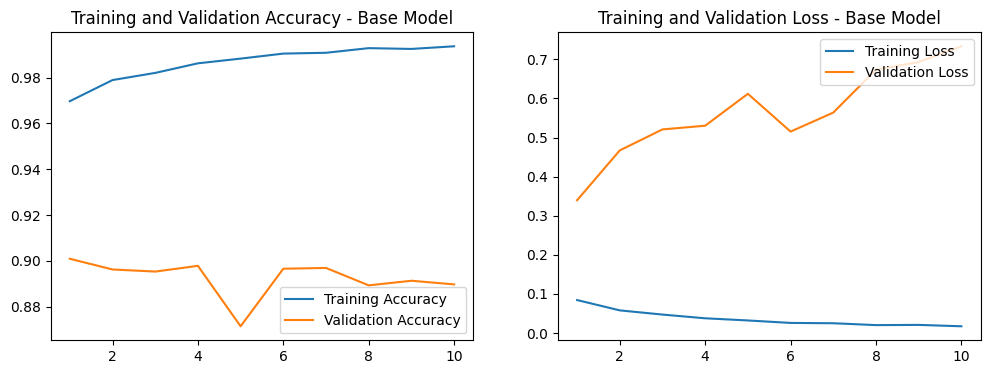

In [88]:
epochs_range = range(1, len(history_base.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_base.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_base.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Base Model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_base.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_base.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Base Model')
plt.show()

375/375 [==============================] - 6s 16ms/step


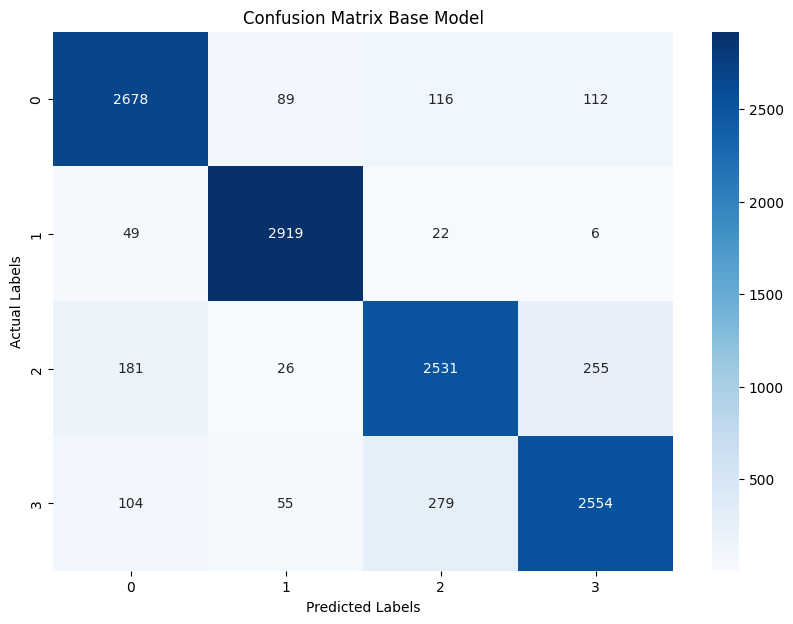

In [89]:
y_pred = model_base.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Base Model')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [90]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision- Base Model: {precision}")
print(f"Recall - Base Model: {recall}")
print(f"F1 Score - Base Model: {f1}")

Precision- Base Model: 0.8913121851874813
Recall - Base Model: 0.8919505678022712
F1 Score - Base Model: 0.8915352929141976


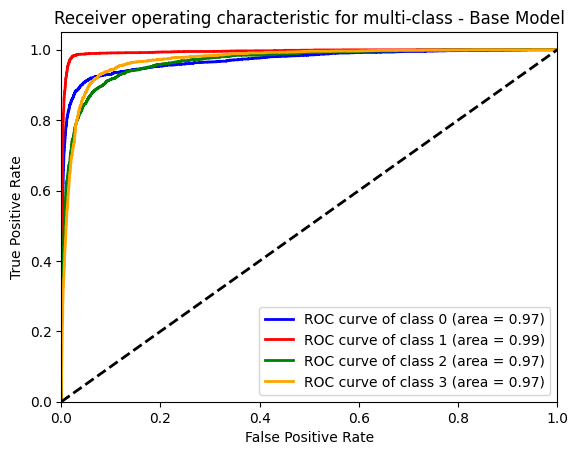

In [91]:
y_test_binarized = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class - Base Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_base.save('part4_model_base.h5')

### Step 4: Evaluation and Optimization

#### DROPOUT

In [60]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [62]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [63]:
model_dropout = Model(inputs=inputs, outputs=outputs)

In [64]:
model_dropout.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_dropout.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddi  (None, 100, 32)           2695360   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 100, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [65]:
history_dropout = model_dropout.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=128)

Epoch 1/10
749/749 [==============================] - 128s 167ms/step - loss: 0.5561 - accuracy: 0.7647 - val_loss: 0.2559 - val_accuracy: 0.9146
Epoch 2/10
749/749 [==============================] - 121s 161ms/step - loss: 0.1985 - accuracy: 0.9369 - val_loss: 0.2672 - val_accuracy: 0.9121
Epoch 3/10
749/749 [==============================] - 123s 164ms/step - loss: 0.1301 - accuracy: 0.9580 - val_loss: 0.3242 - val_accuracy: 0.9097
Epoch 4/10
749/749 [==============================] - 121s 162ms/step - loss: 0.0940 - accuracy: 0.9684 - val_loss: 0.4112 - val_accuracy: 0.9034
Epoch 5/10
749/749 [==============================] - 121s 162ms/step - loss: 0.0726 - accuracy: 0.9748 - val_loss: 0.3869 - val_accuracy: 0.9066
Epoch 6/10
749/749 [==============================] - 122s 163ms/step - loss: 0.0610 - accuracy: 0.9781 - val_loss: 0.5091 - val_accuracy: 0.8965
Epoch 7/10
749/749 [==============================] - 121s 162ms/step - loss: 0.0482 - accuracy: 0.9825 - val_loss: 0.5499 -

In [92]:
print("Training Accuracy Dropout Model:", history_dropout.history['accuracy'][-1])
print("Training Loss Dropout Model:", history_dropout.history['loss'][-1])
print("Validation Accuracy Dropout Model:", history_dropout.history['val_accuracy'][-1])
print("Validation Loss Dropout Model:", history_dropout.history['val_loss'][-1])


Training Accuracy Dropout Model: 0.9878711700439453
Training Loss Dropout Model: 0.03297191113233566
Validation Accuracy Dropout Model: 0.8983801007270813
Validation Loss Dropout Model: 0.661003589630127


In [93]:
test_loss, test_accuracy = model_dropout.evaluate(X_test, y_test)
print("Testing Accuracy Dropout Model:", test_accuracy)
print("Testing Loss Dropout Model:", test_loss)

375/375 [==============================] - 9s 25ms/step - loss: 0.6685 - accuracy: 0.9011
Testing Accuracy Dropout Model: 0.9010521173477173
Testing Loss Dropout Model: 0.6685128211975098


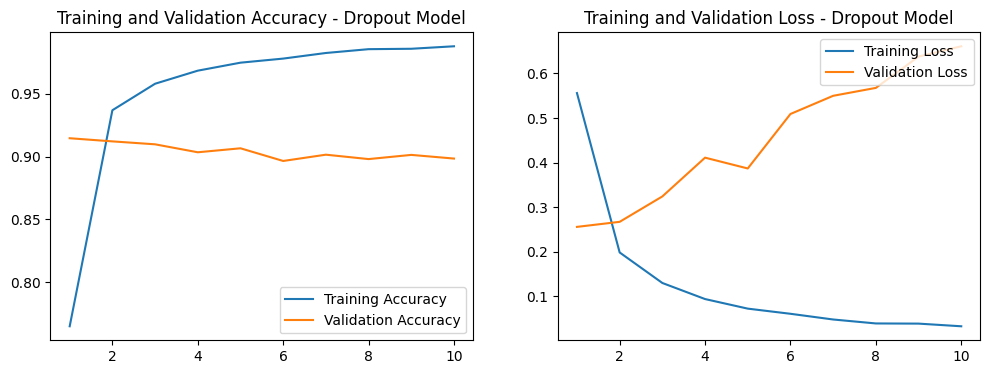

In [94]:
epochs_range = range(1, len(history_dropout.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dropout.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Dropout Model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dropout.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_dropout.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Dropout Model')
plt.show()

375/375 [==============================] - 10s 26ms/step


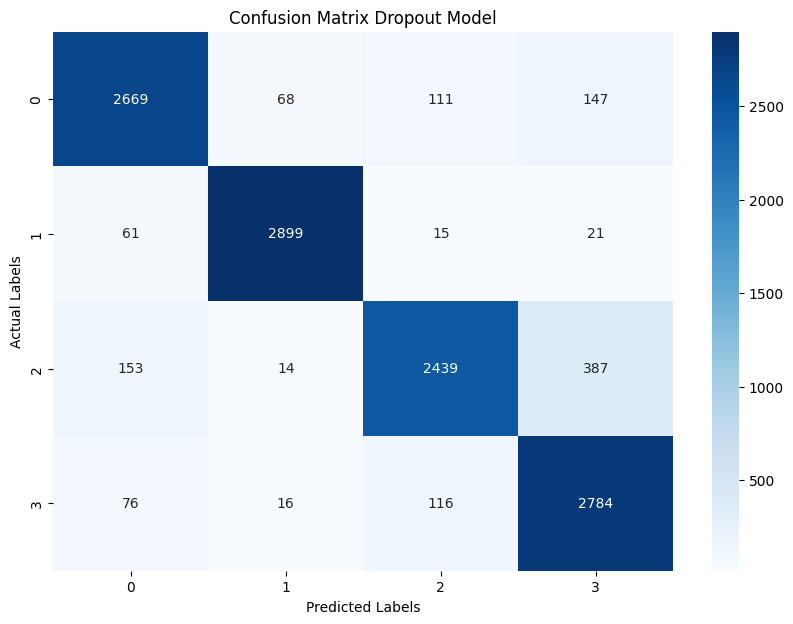

In [95]:
y_pred = model_dropout.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Dropout Model')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [96]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision - Dropout Model: {precision}")
print(f"Recall - Dropout Model: {recall}")
print(f"F1 Score - Dropout Model: {f1}")

Precision - Dropout Model: 0.9032247246847938
Recall - Dropout Model: 0.9010521042084169
F1 Score - Dropout Model: 0.9008165321885174


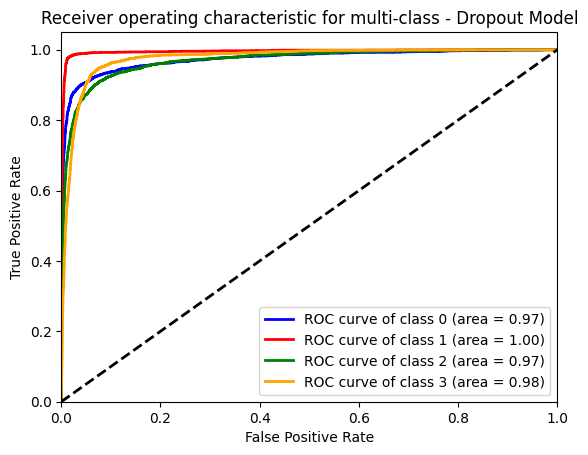

In [97]:
y_test_binarized = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class - Dropout Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_base.save('part4_model_dropout.h5')

#### EARLY STOPPING

In [99]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [100]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [101]:
model_dropout_earlystop = Model(inputs=inputs, outputs=outputs)

In [102]:
model_dropout_earlystop.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_dropout_earlystop.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddi  (None, 100, 32)           2695360   
 ng_3 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_3 (Trans  (None, 100, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0   

In [103]:
history_dropout_earlystop = model_dropout_earlystop.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/10
749/749 [==============================] - 140s 182ms/step - loss: 0.4143 - accuracy: 0.8469 - val_loss: 0.2642 - val_accuracy: 0.9179
Epoch 2/10
749/749 [==============================] - 118s 158ms/step - loss: 0.1897 - accuracy: 0.9401 - val_loss: 0.3294 - val_accuracy: 0.8965
Epoch 3/10
749/749 [==============================] - 155s 207ms/step - loss: 0.1251 - accuracy: 0.9575 - val_loss: 0.3275 - val_accuracy: 0.9092
Epoch 4/10
749/749 [==============================] - 114s 153ms/step - loss: 0.0891 - accuracy: 0.9690 - val_loss: 0.3562 - val_accuracy: 0.9029


In [104]:
print("Training Accuracy Dropout + Early Stopping Model:", history_dropout_earlystop.history['accuracy'][-1])
print("Training Loss Dropout + Early Stopping Model:", history_dropout_earlystop.history['loss'][-1])
print("Validation Accuracy Dropout + Early Stopping Model:", history_dropout_earlystop.history['val_accuracy'][-1])
print("Validation Loss Dropout + Early Stopping Model:", history_dropout_earlystop.history['val_loss'][-1])


Training Accuracy Dropout + Early Stopping Model: 0.9689995050430298
Training Loss Dropout + Early Stopping Model: 0.08907181769609451
Validation Accuracy Dropout + Early Stopping Model: 0.9028891324996948
Validation Loss Dropout + Early Stopping Model: 0.35620683431625366


In [105]:
test_loss, test_accuracy = model_dropout_earlystop.evaluate(X_test, y_test)
print("Testing Accuracy Dropout + Early Stopping Model:", test_accuracy)
print("Testing Loss Dropout + Early Stopping Model:", test_loss)

375/375 [==============================] - 6s 16ms/step - loss: 0.2632 - accuracy: 0.9176
Testing Accuracy Dropout + Early Stopping Model: 0.9175851941108704
Testing Loss Dropout + Early Stopping Model: 0.2632465362548828


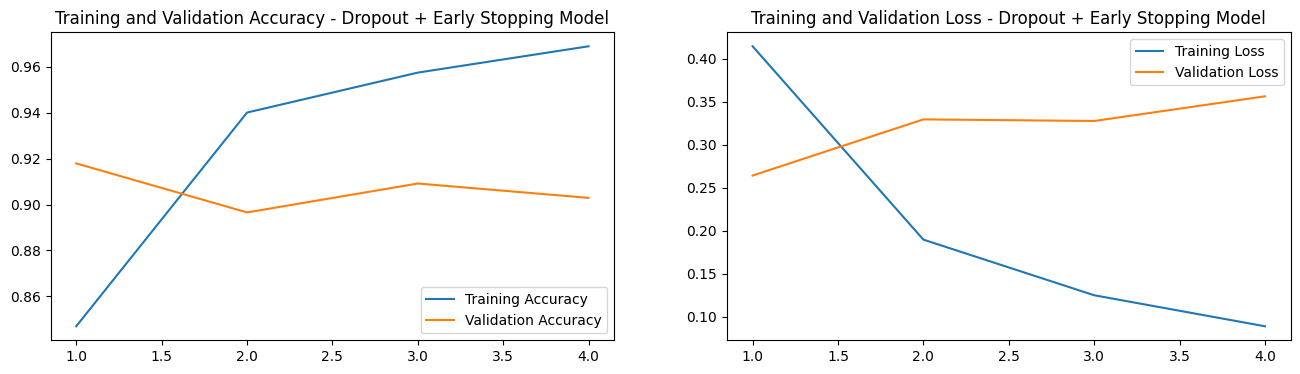

In [107]:
epochs_range = range(1, len(history_dropout_earlystop.history['accuracy']) + 1)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dropout_earlystop.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dropout_earlystop.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Dropout + Early Stopping Model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dropout_earlystop.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_dropout_earlystop.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Dropout + Early Stopping Model')
plt.show()

375/375 [==============================] - 6s 15ms/step


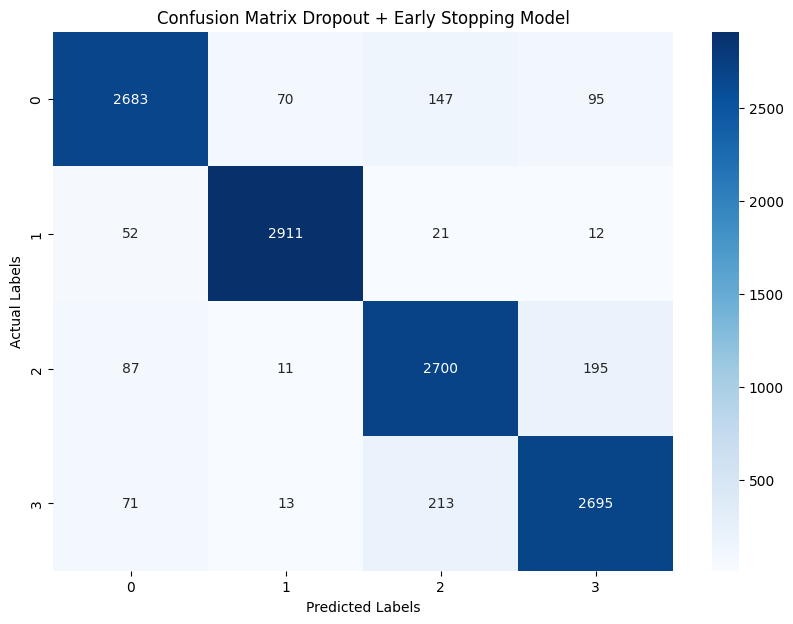

In [108]:
y_pred = model_dropout_earlystop.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Dropout + Early Stopping Model')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [109]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision - Dropout + Early Stopping Model: {precision}")
print(f"Recall - Dropout + Early Stopping Model: {recall}")
print(f"F1 Score - Dropout + Early Stopping Model: {f1}")

Precision - Dropout + Early Stopping Model: 0.9179411715306981
Recall - Dropout + Early Stopping Model: 0.9175851703406813
F1 Score - Dropout + Early Stopping Model: 0.9176474047846841


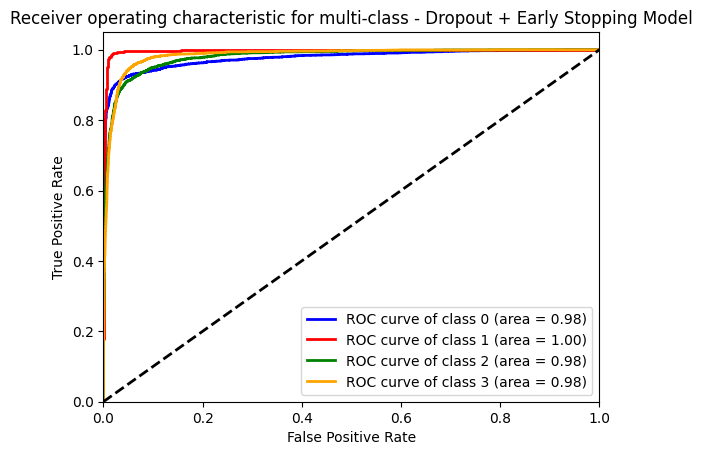

In [110]:
y_test_binarized = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class - Dropout + Early Stopping Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_base.save('part4_model_dropout_earlystop.h5')

#### REGULARIZATION

In [111]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Dense(embed_dim, kernel_regularizer=l2(0.01)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [113]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu", kernel_regularizer=l2(0.01))(x)
outputs = layers.Dense(4, activation="softmax", kernel_regularizer=l2(0.01))(x)

In [114]:
model_dropout_earlystop_regularize = Model(inputs=inputs, outputs=outputs)

In [115]:
model_dropout_earlystop_regularize.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_dropout_earlystop_regularize.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 token_and_position_embeddi  (None, 100, 32)           2695360   
 ng_4 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_4 (Trans  (None, 100, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_4  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0   

In [116]:
history_dropout_earlystop_regularize = model_dropout_earlystop_regularize.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/10
749/749 [==============================] - 152s 195ms/step - loss: 0.5349 - accuracy: 0.8064 - val_loss: 0.3001 - val_accuracy: 0.9111
Epoch 2/10
749/749 [==============================] - 145s 193ms/step - loss: 0.2280 - accuracy: 0.9346 - val_loss: 0.2910 - val_accuracy: 0.9137
Epoch 3/10
749/749 [==============================] - 120s 160ms/step - loss: 0.1552 - accuracy: 0.9552 - val_loss: 0.3247 - val_accuracy: 0.9085
Epoch 4/10
749/749 [==============================] - 119s 158ms/step - loss: 0.1125 - accuracy: 0.9672 - val_loss: 0.4255 - val_accuracy: 0.9083
Epoch 5/10
749/749 [==============================] - 118s 158ms/step - loss: 0.0892 - accuracy: 0.9742 - val_loss: 0.4588 - val_accuracy: 0.9039


In [117]:
print("Training Accuracy Dropout + Early Stopping + Regularized Model:", history_dropout_earlystop_regularize.history['accuracy'][-1])
print("Training Loss Dropout + Early Stopping + Regularized Model:", history_dropout_earlystop_regularize.history['loss'][-1])
print("Validation Accuracy Dropout + Early Stopping + Regularized Model:", history_dropout_earlystop_regularize.history['val_accuracy'][-1])
print("Validation Loss Dropout + Early Stopping + Regularized Model:", history_dropout_earlystop_regularize.history['val_loss'][-1])


Training Accuracy Dropout + Early Stopping + Regularized Model: 0.9742289185523987
Training Loss Dropout + Early Stopping + Regularized Model: 0.08923716098070145
Validation Accuracy Dropout + Early Stopping + Regularized Model: 0.9038910865783691
Validation Loss Dropout + Early Stopping + Regularized Model: 0.45877504348754883


In [118]:
test_loss, test_accuracy = model_dropout_earlystop_regularize.evaluate(X_test, y_test)
print("Testing Accuracy Dropout + Early Stopping + Regularized Model:", test_accuracy)
print("Testing Loss Dropout + Early Stopping + Regularized Model:", test_loss)

375/375 [==============================] - 6s 17ms/step - loss: 0.2852 - accuracy: 0.9113
Testing Accuracy Dropout + Early Stopping + Regularized Model: 0.9113226532936096
Testing Loss Dropout + Early Stopping + Regularized Model: 0.28517401218414307


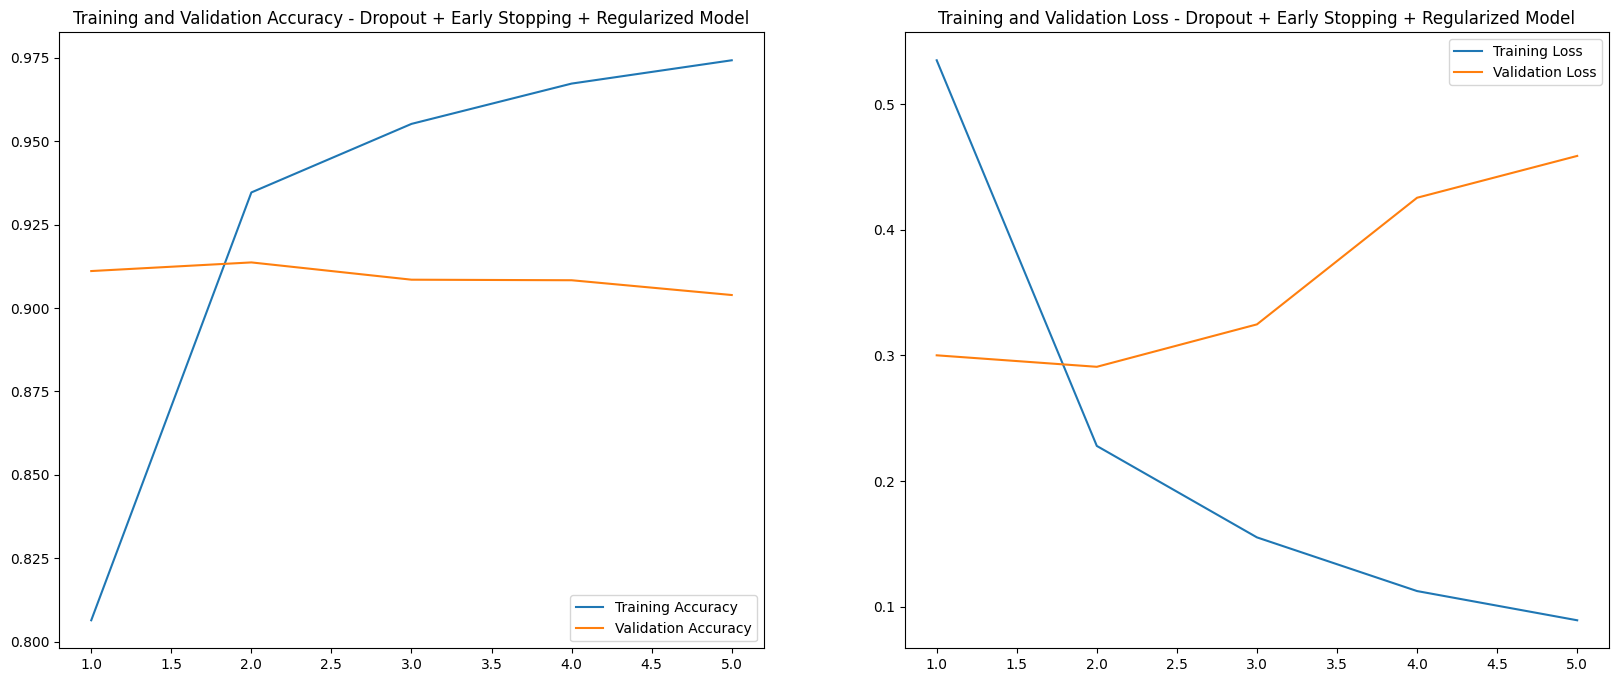

In [119]:
epochs_range = range(1, len(history_dropout_earlystop_regularize.history['accuracy']) + 1)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dropout_earlystop_regularize.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_dropout_earlystop_regularize.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Dropout + Early Stopping + Regularized Model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dropout_earlystop_regularize.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_dropout_earlystop_regularize.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Dropout + Early Stopping + Regularized Model')
plt.show()

375/375 [==============================] - 6s 14ms/step


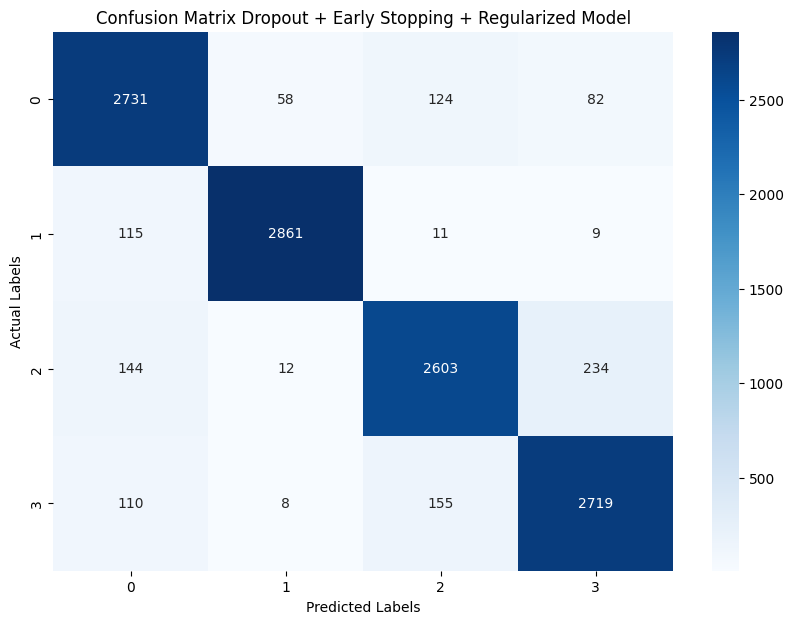

In [120]:
y_pred = model_dropout_earlystop_regularize.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Dropout + Early Stopping + Regularized Model')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [121]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f"Precision - Dropout + Early Stopping + Regularized Model: {precision}")
print(f"Recall - Dropout + Early Stopping + Regularized Model: {recall}")
print(f"F1 Score - Dropout + Early Stopping + Regularized Model: {f1}")

Precision - Dropout + Early Stopping + Regularized Model: 0.911866511081033
Recall - Dropout + Early Stopping + Regularized Model: 0.9113226452905812
F1 Score - Dropout + Early Stopping + Regularized Model: 0.911425271275497


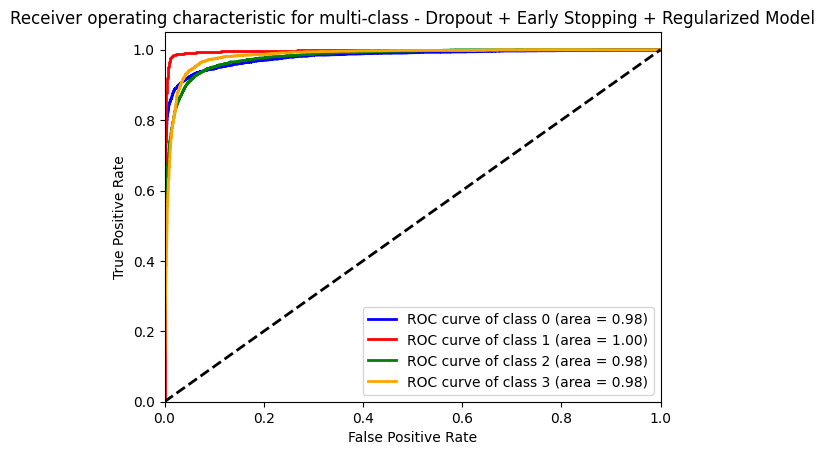

In [122]:
y_test_binarized = label_binarize(y_test, classes=[0,1,2,3])
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class - Dropout + Early Stopping + Regularized Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
model_base.save('model_dropout_earlystop_regularized.h5')